In [1]:
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#%matplotlib qt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# HOG and Color features

In [2]:
orient=9
pix_per_cell=8
cell_per_block=2
spatial_size=32
hist_bins=32

def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features
    
def get_hog_features_all(img):
    hog_features1 = get_hog_features(img[:,:,0], feature_vec=True)
    hog_features2 = get_hog_features(img[:,:,1], feature_vec=True)
    hog_features3 = get_hog_features(img[:,:,2], feature_vec=True)
    return np.hstack((hog_features1, hog_features2, hog_features3))

def bin_spatial(img):
    size=(spatial_size, spatial_size)
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img):
    nbins=hist_bins
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_image_features(img):
    img_conv = convert_color(img)
    spatial_features = bin_spatial(img_conv)
    hist_features = color_hist(img_conv)
    hog_features = get_hog_features_all(img_conv)
    return np.hstack((spatial_features, hist_features, hog_features))

Image shape (64, 64, 3)
HOG shape (1764,)
Color hist shape: (96,)


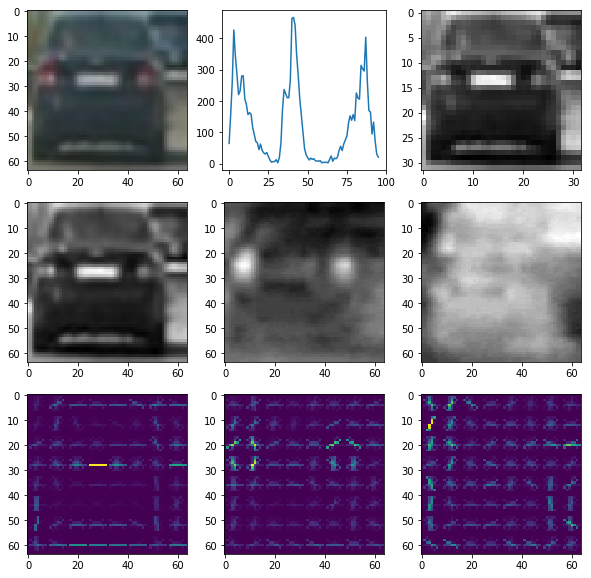

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

img = mpimg.imread('data/vehicles/GTI_MiddleClose/image0000.png')
print('Image shape', img.shape)
axes[0,0].imshow(img)

img_conv = convert_color(img)
axes[1,0].imshow(img_conv[:,:,0], cmap='gray')
axes[1,1].imshow(img_conv[:,:,1], cmap='gray')
axes[1,2].imshow(img_conv[:,:,2], cmap='gray')

hog_features1, hog_image1 = get_hog_features(img_conv[:,:,0], vis=True)
hog_features2, hog_image2 = get_hog_features(img_conv[:,:,1], vis=True)
hog_features3, hog_image3 = get_hog_features(img_conv[:,:,2], vis=True)
print('HOG shape', hog_features1.shape)
axes[2,0].imshow(hog_image1)
axes[2,1].imshow(hog_image2)
axes[2,2].imshow(hog_image3)
mpimg.imsave('output_images/image0000_hog1.jpg', hog_image1)

hist_features = color_hist(img_conv)
print('Color hist shape:', hist_features.shape)
axes[0,1].plot(hist_features)

spatial_features = bin_spatial(img_conv)
axes[0,2].imshow(spatial_features[0:spatial_size*spatial_size].reshape(spatial_size,spatial_size), cmap='gray')

# Load data

In [11]:
def load_images_features(path):
    features = []
    for fname in glob.glob(path):
        img = mpimg.imread(fname)
        img_features = get_image_features(img)
        features.append(img_features)
    return np.array(features)

In [12]:
%%time 
vehicles_features = load_images_features('data/vehicles/**/**.png')
nonvehicles_features = load_images_features('data/non-vehicles/**/**.png')
print('Vehicles:', vehicles_features.shape)
print('Non-vehicles:', nonvehicles_features.shape)

Vehicles: (8792, 8460)
Non-vehicles: (8968, 8460)
Wall time: 1min 56s


In [13]:
X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Scale
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Training data:', X_train.shape)
print('Test data:', X_test.shape)

Training data: (14208, 8460)
Test data: (3552, 8460)


# Train SVC

In [14]:
svc = LinearSVC()
%time svc.fit(X_train, y_train)
%time print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Wall time: 5.98 s
Test Accuracy of SVC =  0.993
Wall time: 55 ms


In [15]:
pickle.dump((svc, X_scaler), open('svc_linear_993.p', 'wb'))

# Window Search

In [3]:
(svc, X_scaler) = pickle.load(open('svc_linear_993.p', 'rb'))

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler):
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, feature_vec=False)
    hog2 = get_hog_features(ch2, feature_vec=False)
    hog3 = get_hog_features(ch3, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

def draw_bboxes(img, bbox_list):
    for bbox in bbox_list:
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
    return img
        
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars_multiscale(img, ystart, ystop, scales, svc, X_scaler):
    bbox_list = []
    for scale in scales:
        bbox_list = bbox_list + find_cars(img, ystart, ystop, scale, svc, X_scaler)
    return bbox_list

Wall time: 496 ms


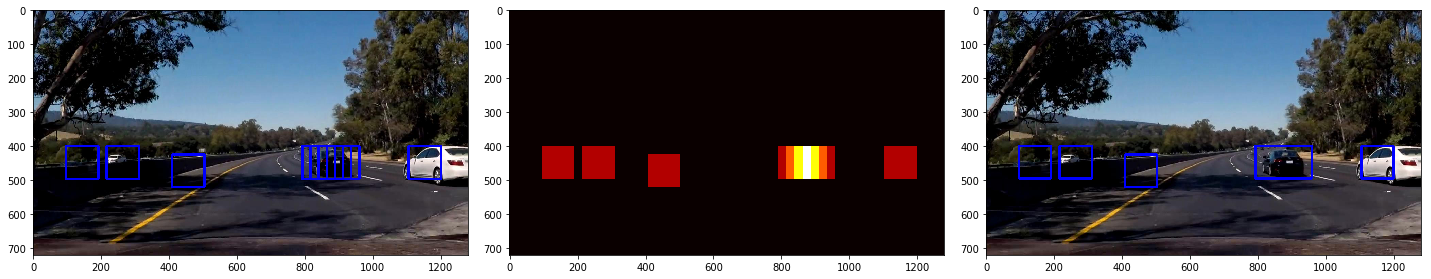

In [8]:
ystart = 400
ystop = 656
scales = [1.5]
heat_threshold = 1

fname = 'video41.jpg'
img = mpimg.imread('test_images/' + fname)

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
fig.tight_layout()

%time bbox_list = find_cars_multiscale(img, ystart, ystop, scales, svc, X_scaler)
out_img = draw_bboxes(np.copy(img), bbox_list)
axes[0].imshow(out_img)
mpimg.imsave('output_images/' + fname.replace('.jpg', '_boxes.jpg'), out_img)

heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, bbox_list)
heat = apply_threshold(heat, heat_threshold)
axes[1].imshow(np.clip(heat, 0, 255), cmap='hot')
mpimg.imsave('output_images/' + fname.replace('.jpg', '_heat.jpg'), np.clip(heat, 0, 255), cmap='hot')

labels = label(heat)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
axes[2].imshow(draw_img)
mpimg.imsave('output_images/' + fname.replace('.jpg', '_cars.jpg'), draw_img)

# Video

In [33]:
ystart = 400
ystop = 656
scales = [1.5]
heat_threshold = 1
heat_cum_threshold = 10
heat_cum_decay = 10

def process(img):
    global heat_cum
    
    bbox_list = find_cars_multiscale(img, ystart, ystop, scales, svc, X_scaler)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)    
    heat[heat>=heat_threshold] = 1
    heat[heat==0] = -heat_cum_decay
    
    heat_cum = np.maximum(heat_cum + heat, 0)
    
    heat_mask = apply_threshold(np.copy(heat_cum), heat_cum_threshold)
    
    labels = label(heat_mask)
    img = draw_labeled_bboxes(img, labels)
    return img

In [38]:
# Run process on videos

input_dir = './'
output_dir = 'output_videos/'
fname = 'test_video.mp4'

heat_cum = np.zeros_like(img[:,:,0]).astype(np.float)

clip_in = VideoFileClip(input_dir + fname)
clip_out = clip_in.fl_image(process)
clip_out.write_videofile(output_dir + fname, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_dir + fname))

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:24<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 



In [7]:
# Save frame
clip = VideoFileClip('project_video.mp4')
clip.save_frame('test_images/video41.jpg', 41.6)